> _Author:_ Grégoire Pacreau

# Spectrograms and Regime Change Detection

In this example we show how Koopman theory can be used to analyze the behaviour of a switching system, validating our results with Fourier theory. We study a simple signal composed by a sum of a small number of sinusoidal functions. These signals are easily analyzed using Fourier theory, but similar results can be obtained via Koopman theory and its implementation in `kooplearn`. In particular, we show that how to recover changes in the signal by detecting changes in the underlying process. Here, this will be modeled by a sudden change of the dominant frequencies of the signal during a _switching_ period.

## Data generation 

In [1]:
import importlib

for module in ['kooplearn', 'matplotlib', 'tqdm', 'pandas']:
    try:
        importlib.import_module(module)
    except ImportError:
        %pip install {module}

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from kooplearn.abc import BaseModel

np.random.seed(0) # Reproducible results

We now generate a synthetic signal for our analysis. Our dataset will have $10000$ points of the signal's trajectory, all observed at a regular interval of one $0.01 \, {\rm s}$. We also set that between $t = 4000$ and $t = 4500$ it occurs a ragime change in which the dominant frequencies of the signal change.

In [3]:
N = 10000 # Trajectory steps
start_regime_change = 4000
end_regime_change = 4500

In the following we define a function that given an input array `i` representing time and a list of frequencies `freqs` returns the signal observed at each time step.

In [4]:
def gen_signal(i, freqs):
    X = np.zeros(i.shape[0])
    for f in freqs:
        X += np.sin(i*f*2*np.pi)
    return X

We can now create our signal. The signal in the first regime has frequencies 2Hz, 8Hz, 13Hz and 15Hz. The signal in the second regime has frequencies 5Hz and 7Hz.

In [5]:
i = np.arange(N)/100

# REGIME 1
X1 = gen_signal(i, [2, 8, 13, 15])
    
# REGIME 2
X2 = gen_signal(i, [5, 7])

# Mixing the regimes
X_no_noise = np.concatenate([X1[:start_regime_change], 
                    X2[start_regime_change:end_regime_change],
                    X1[end_regime_change:]])

The signal is then perturbed by an additive noise with a small variance compared to the values taken by the signal.

In [6]:
noise = 0.2*np.random.randn(N)
X = X_no_noise + noise

Let us plot the trajectories of our dataset:

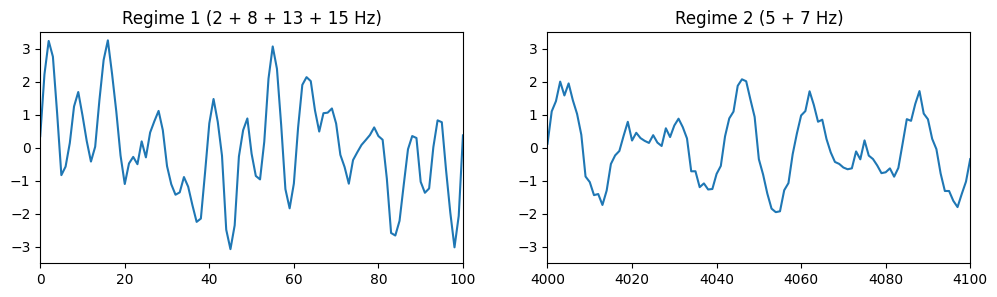

In [7]:
plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
plt.plot(X[:101])
plt.ylim((-3.5, 3.5))
plt.margins(x = 0)
plt.title('Regime 1 (2 + 8 + 13 + 15 Hz)')

plt.subplot(1, 2, 2)
plt.plot(np.arange(4000, 4101), X[4000:4101])
plt.ylim((-3.5, 3.5))
plt.title('Regime 2 (5 + 7 Hz)')
plt.margins(x = 0)
plt.show()

Let us verify that we do recover those frequencies using the classical Fourier spectrogram as implemented in ``scipy.signal``.

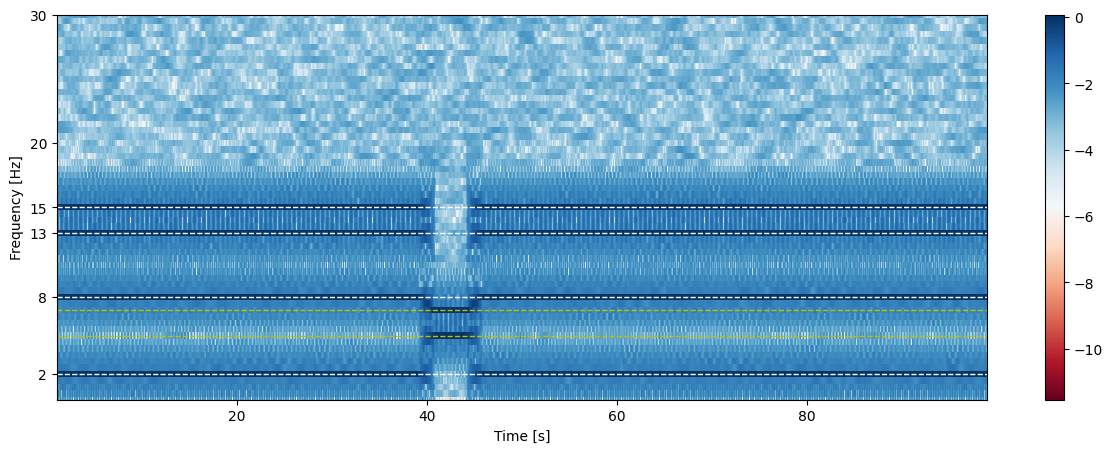

In [8]:
from scipy import signal

n_seg = 200
res_spectrogram = signal.spectrogram(X, 100, scaling='density', nperseg=n_seg, noverlap=199)

# Plotting spectrogram
plt.figure(figsize=(15,5))
plt.grid(False)
plt.pcolormesh(res_spectrogram[1], 
            res_spectrogram[0], 
            np.log10(res_spectrogram[2]), 
            cmap='RdBu')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.yticks([2, 8, 13, 15, 20, 30, 40, 50])
plt.ylim(0, 30)
plt.axhline(y=2, color='w', linestyle='--', lw=1)
plt.axhline(y=8, color='w', linestyle='--', lw=1)
plt.axhline(y=13, color='w', linestyle='--', lw=1)
plt.axhline(y=15, color='w', linestyle='--', lw=1)
plt.axhline(y=5, color='y', linestyle='--', lw=1)
plt.axhline(y=7, color='y', linestyle='--', lw=1)
plt.colorbar()
plt.show()

## Koopman model

We now show that fitting a Koopman operator enables a complete characterization of the dynamics. The first step to fit a Koopman model with kooplearn is to organize the data according to the [paradigm based on context windows](kooplearn_data_paradigm). Since in this case we have a single trajectory we can use the utility function {meth}`kooplearn.data.traj_to_contexts`. We set the context size to $200$, matching our choice for the Fourier spectrogram.

In [9]:
from kooplearn.data import traj_to_contexts

CONTEXT_LENGTH = 100

dataset = traj_to_contexts(X, context_window_len = CONTEXT_LENGTH)

n_pts, ctx_len, _ = dataset.shape
print(f"Dataset has {n_pts} context windows of size {ctx_len}.")

Dataset has 9901 context windows of size 100.


We now take a small subset of the full dataset and fit a Koopman model on it. For this example we will use kernel methods, and specifically the _Reduced Rank Regression_ described in {footcite:t}`Kostic2022`. We use a combination of linear and Gaussian (i.e. RBF) kernels, the latter of which with a length-scale corresponding to the median heuristic.

In [10]:
from sklearn.gaussian_process.kernels import DotProduct, RBF
from kooplearn.models.kernel import Kernel
from scipy.spatial.distance import pdist

train_contexts = dataset[:500]

median_heuristic_lengthscale = np.median(pdist(X.reshape(-1, 1)))
kernel = 0.5*(DotProduct() + RBF(length_scale=median_heuristic_lengthscale))
model = Kernel(reduced_rank= True, kernel=kernel, rank=8, tikhonov_reg=1e-5)
model.fit(train_contexts)

The dominant frequencies of the dynamics $\omega_{i}$ are related to the Koopman eigenvalues $\lambda_{i}$ by the relation $\omega_{i} = \frac{1}{2\pi \Delta t}\deg (\lambda_{i})$, with $\Delta t$ being the time lag between samples. By evaluating `model.eig()` we can see that the Koopman model perfectly recover the frequencies of the signal:

In [11]:
dominant_frequencies = 100*np.angle(model.eig())/(2*np.pi)
for f in dominant_frequencies:
    if f > 0: # Koopman eigenvalues come in complex-conjugate paris. Discarting the eigenvalues with negative imaginary part.
        print(f"Found {f:.3f} Hz as a dominant freqency of the dynamics")

Found 15.003 Hz as a dominant freqency of the dynamics
Found 13.000 Hz as a dominant freqency of the dynamics
Found 8.000 Hz as a dominant freqency of the dynamics
Found 2.000 Hz as a dominant freqency of the dynamics


The Koopman model can be used also to forecast the signal (and any observable of it). By taking a validation subset of the full data, we can verify that the forecast is very accurate as well.

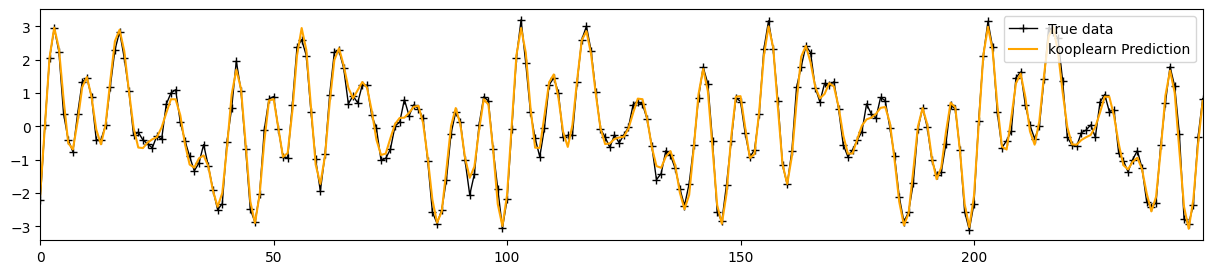

In [12]:
val_contexts = dataset[5000:5250]

plt.figure(figsize=(15,3))
X_pred = np.squeeze(model.predict(val_contexts))
X_true = np.squeeze(val_contexts.lookforward(model.lookback_len))

plt.plot(X_true, '+-', label='True data', lw=1, color='k')
plt.plot(X_pred, label='kooplearn Prediction', color='orange')
plt.margins(x=0)
plt.legend()
plt.show()

## Koopman spectral decomposition and spectrogram

Now that we have selected a good kernel, we can now use it to train koopman operators on subsets of the dataset and examine their modes.

The koopman spectrogram works the same as its Fourier equivalent in the sense that it estimates the frequencies for data in a sliding window. The main differences lies in the fact that we need to define the hyperparameters of the koopman operators as well as the parameters of the sliding window. A new koopman operator using the set hyperparameters will be learned on every window and its eigenvalues and modes saved, so that we can observe the evolution of the dynamic for each step. We then plot for each window the learned frequencies and amplitudes.

The spectrogram can be computed using the function ``kooplearn.signal.analysis``, which takes the following parameters:
 - X : the time series on which spectral analysis will be run;
 - model : an untrained kooplearn model with fixed hyperparameters;
 - N : the number of samples used for fitting the model (i.e. the size of the sliding window);
 - steps : the number of steps by which the sliding window advances at each iteration;
 - T : how long in the past should the context look (for a d-dimensional time series, the resulting states will be of dimension d*T);
 - observable : the observable through which to compute the modes (by default the identity mapping);
 - deltat : the time between steps in seconds.

In [13]:
import pandas

def compute_mode_info(operator:BaseModel, use_observables=True, X=None, deltat=1, xcoord=None, ycoord=None):
    # computes mode information from a kooplearn.basemodel

    if X is None:
        X = operator.data_fit

    # compute modes
    modes, eigs = operator.modes(X, predict_observables=use_observables)

    # modes have dimensions : (number of modes, time steps, context length, feature size)

    # if there are observables, extract them from the resulting dictionary
    # Only the last context from the last mode is used for our analysis since we study f(X_t)
    if use_observables:
        modes = modes['obs_of_interest'][:,-1, -1]

    # compute eigenvalues
    n_eigs = eigs.shape[0]
    if modes.ndim == 1:
        n_features=1
    else:
        n_features = modes.shape[-1]

    # initialiasing the dataframe containing the information for every cell of every mode
    infos = pandas.DataFrame()
    infos['eig_num'] = np.repeat(np.arange(n_eigs), n_features)  # Identifying the mode number
    infos['var_index'] = np.tile(np.arange(n_features), n_eigs)  # Unique identifier for each variable
    if xcoord is None:  # If no specific coordinate is given, each dimensionis
        infos['x'] = np.tile(np.arange(n_features),
                                      n_eigs)  # identified with its index in the observable array
    else:  # Otherwise coordinates are saved for accurate plotting
        infos['x'] = xcoord
    if ycoord is not None:  # If y coordinates make sense, save them as well
        infos['y'] = ycoord

    # eigenvalue related information. This information is shared by every variable, hence the use of repeat
    infos['eigval real'] = np.repeat(eigs.real, n_features)  # Real part
    infos['eigval imag'] = np.repeat(eigs.imag, n_features)  # Imaginary part

    infos['modulus'] = np.repeat(np.abs(eigs) ** (1 / deltat), n_features)  # Modulus of the mode
    angles = np.log(eigs)
    freqs = angles.imag / (2 * np.pi * deltat)
    infos['frequency'] = np.repeat(freqs, n_features)  # Frequency of the mode

    # mode specific information. This information is unique per mode and per variable
    infos['mode'] = modes.flatten()  # Actual value of the mode
    if n_features == 1:
        Z = eigs*modes.flatten()
    else:
        Z = modes * np.outer(eigs, np.ones(n_features))  # Multiplying by the eigenvalue to recover the signal
    Z = Z.flatten()  # Row-wise flattening of the modes matrix
    infos['amplitude'] = np.abs(Z) # Amplitude of the mode at every point
    infos['phase'] = np.arctan(Z.imag / Z.real)  # Phase of the mode at every point

    return infos

def spectrogram(trajectory, modelClass:BaseModel, window_size, steps, context_length, observable=lambda x:x, deltat=1.):
    """
    X one dimensional time series
    model
    window_size = 500 # number of samples for each training
    steps = 10   # step size of the moving window
    T=200         # number of time steps at each state
    observable : a function that applies on each time step of the trajectory (if X is of shape (N, d), a function from R^d to R^m, m being any integer)
    """
    ctxs = traj_to_contexts(trajectory, context_window_len=context_length)

    # applying the observable function to the trajectory:
    if trajectory.ndim == 1:
        trajectory = trajectory.reshape((-1, 1))
    fX = np.apply_along_axis(observable, 1, trajectory)
    obs_ctxs = traj_to_contexts(fX, context_window_len=CONTEXT_LENGTH-1)

    N = ctxs.shape[0]
    r = modelClass.rank

    # counting features of the observable:
    altered_traj = np.apply_along_axis(observable, 0, trajectory)
    if altered_traj.ndim == 1:
        n_features = 1
    else:
        n_features = altered_traj.shape[-1]
        
    freqs = np.zeros(((N-window_size-T)//steps, r*n_features))
    amplitudes = np.zeros(((N-window_size-T)//steps, r*n_features))
    phases = np.zeros(((N-window_size-T)//steps, r*n_features))
    modulus = np.zeros(((N-window_size-T)//steps, r*n_features))

    for i in tqdm(range((N-window_size-T)//steps)):

        partial_dataset = ctxs[i*steps:(i+1)*steps+window_size]

        # Manually adding observables (TODO: in future versions, addind observables will be streamlined)
        partial_dataset.observables = {
            'obs_of_interest': obs_ctxs.data[i*steps:(i+1)*steps+window_size] # must have same size than training dataset, but only the last sample will be used
        }

        model = deepcopy(modelClass)
        model.fit(partial_dataset)

        infos = compute_mode_info(model, use_observables=True, deltat=deltat, xcoord=None)
        freqs[i] = infos['frequency']
        amplitudes[i] = infos['amplitude']
        modulus[i] = infos['modulus']
        phases[i] = infos['phase']
        del model

    return freqs, phases, amplitudes, modulus

Contrary to a Fourier spectrogram, the Koopman spectrogram does not provide an amplitude for all frequencies. Indeed, Koopman theory recovers the specific frequencies that are predominant in the dynamic. This leads to a sparser representation than the Fourier spectrogram that is more easily readable. Furthermore, the Koopman spectrogram is not dependent on a discretisation of the frequency space and may be more precise than Fourier.

Here are the parametes that we will use for building the Koopman spectrogram of our series:

In [14]:
# Parameters of the spectrogram
N = 100        # Number of samples (of states) for each training round
steps = 10     # Step size between two training (speed of the moving window)
T=100          # Number of time steps composing each state

We provide here the code for estimating a function of the trajectory. For the purpose of this example, we will only study the trajectory itself, so the function will be the identity. If you are interested in the behaviour a function of your trajectory (for instance a polynomial), just modify *f*. If your time series is multidimensional (let us set $p$ the number of dimensions), and you want to study the spectrogram associated to only one dimension, *f* would be a projector, i.e. a function that takes a $p$-dimensional array and returns a $1$-dimensional array.

In [15]:
# function (here is the identity)
f = lambda x : x
# example of projector: f = lambda x : np.array([x[0]])

We will furthermore use the ``kooplearn`` model's hyperparameters we selected in the previous section. We can now learn the Koopman spectrogram :

In [18]:
# Learning the spectrogram
freqs, phases, amplitudes, modulus = spectrogram(X, model, N, steps, T, observable=f, deltat=0.01)

100%|██████████| 970/970 [00:59<00:00, 16.24it/s]


And plot the resulting spectrogram:

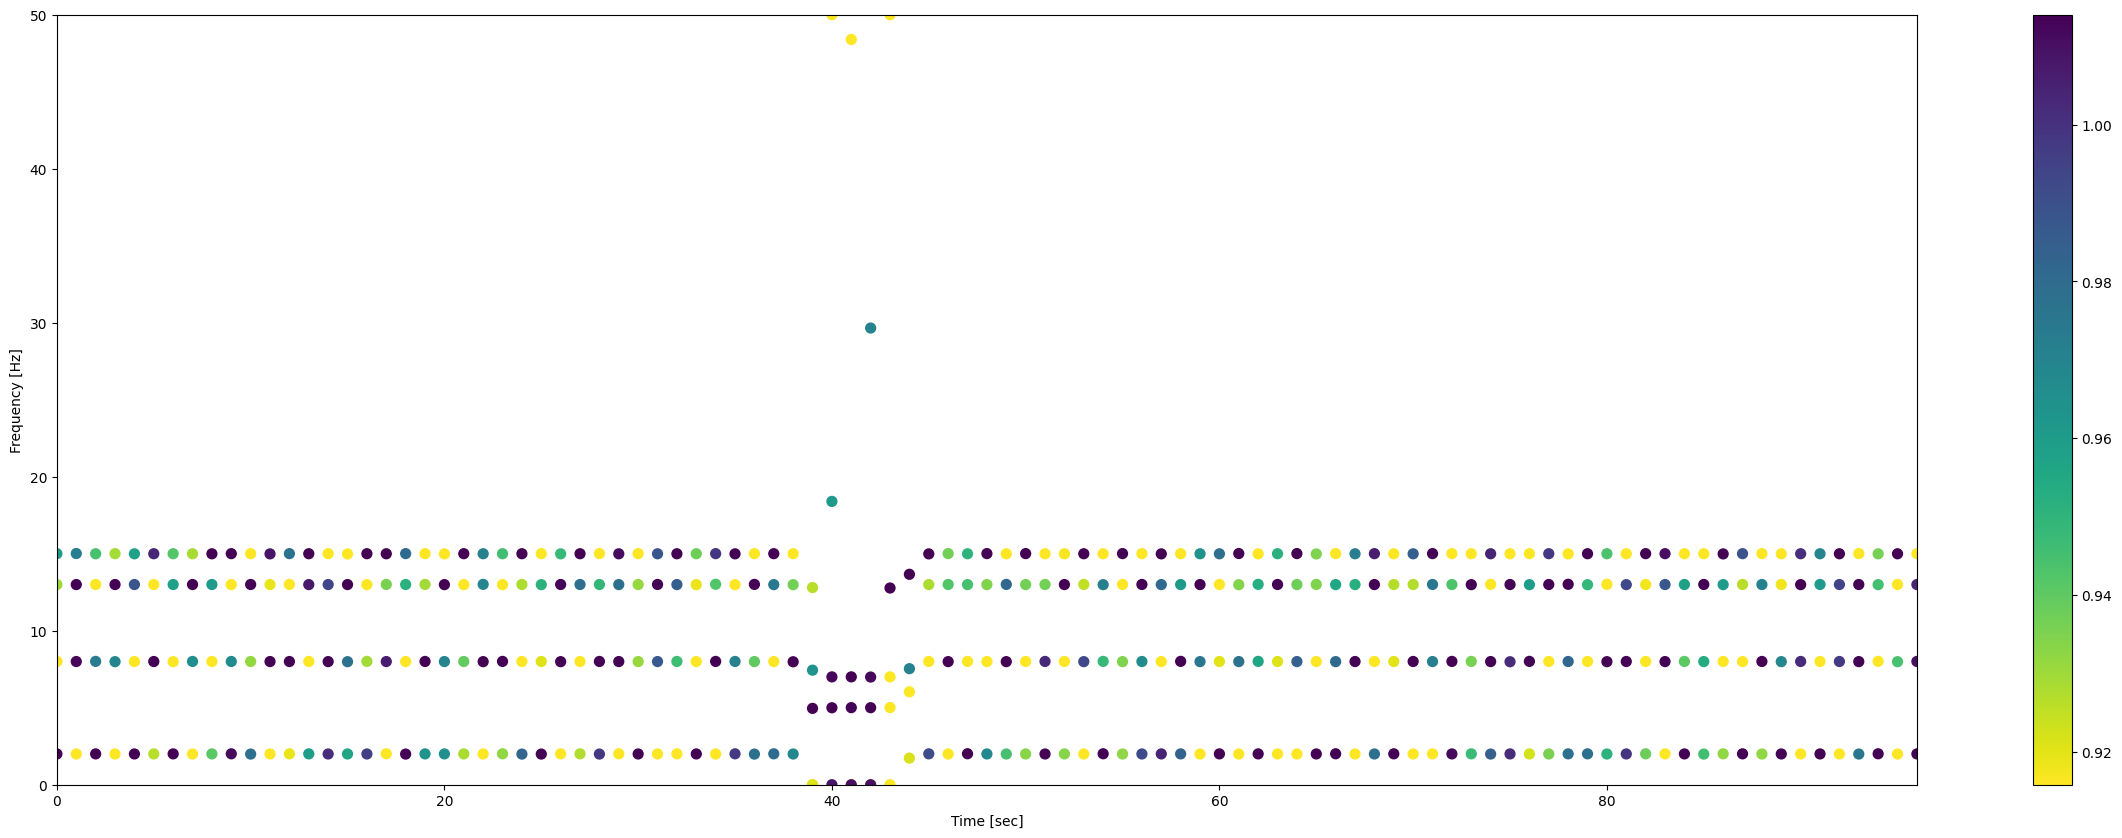

In [19]:
# Plotting the spectrogram
plt.figure(figsize=(30,10))
amplitudes[freqs <= 0] = np.nan                          # dropping values for negative freqs
secs = np.arange(freqs.shape[0])/10                      # X axis in seconds
xs = np.outer(secs, np.ones(freqs.shape[1]))             # reformatting for plt scatter
for i in range(0, xs.shape[0], 10):
    plt.scatter(x=xs[i], y=freqs[i], c=modulus[i], cmap='viridis_r', s=50)
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.margins(x=0, y=0)
plt.ylim(0, 50)
plt.show()

Observe that we do recover the correct frequencies. When the signal is composed of only two frequencies, they appear with high ammplitude in the koopman operator. Other noisy frequencies are selected since the rank of the ``kooplearn`` model was larger than 4, but as expected they have a smaller amplitude since they are not truely part of the signal. We also observe that frequencies at the margin of the two regimes are slightly meaned, which is an effect of the sliding window that is also observed in the Fourier spectrogram. Reducing the size of the moving window will reduce this blending of frequencies at the cost of a lower precision.

## Regime change detection

Since the Koopman spectrogram selects specific frequencies, we can use them to automatically detect regime changes through clustering. In this section, we recover the two regimes of our synthetic dataset using DBSCAN.

First, notice that the frequencies given by mode decomposition are always in the same order. To homogenize our vectors we must sort them in increasing order. Do notice that if the rank of the model is overestimated, the frequency vector will contain many unreliable frequencies that can alter the position of the relevant ones. For instance, in the second regime of our data, the Koopman operator with rank 8 has 4 frequencies of low amplitude that change randomly between windows. One should consider either filtering out these noisy frequencies before clustering or reducing the rank of the Koopman operator.

In [20]:
# sorting frequencies
sorted_freqs = np.sort(freqs, axis=-1)

Now that we have vectors of frequencies for each  window, we can apply the DBSCAN algorithm to cluster the time-series in several modes.

In [21]:
from sklearn.cluster import DBSCAN
cls = DBSCAN(eps=0.02)
classes = cls.fit_predict(sorted_freqs)
first_regime = classes == 0      # boolean array identifying the first regime
second_regime = classes != 0     # boolean array indentifying the second regime

# cosmetic change to the classes (they should overlap so that to avoid gaps when plotting)
for k in range(1, second_regime.shape[0]):
    if not second_regime[k-1] and second_regime[k] :
        second_regime[k-1] = True
    if not first_regime[k-1] and first_regime[k] :
        first_regime[k-1] = True

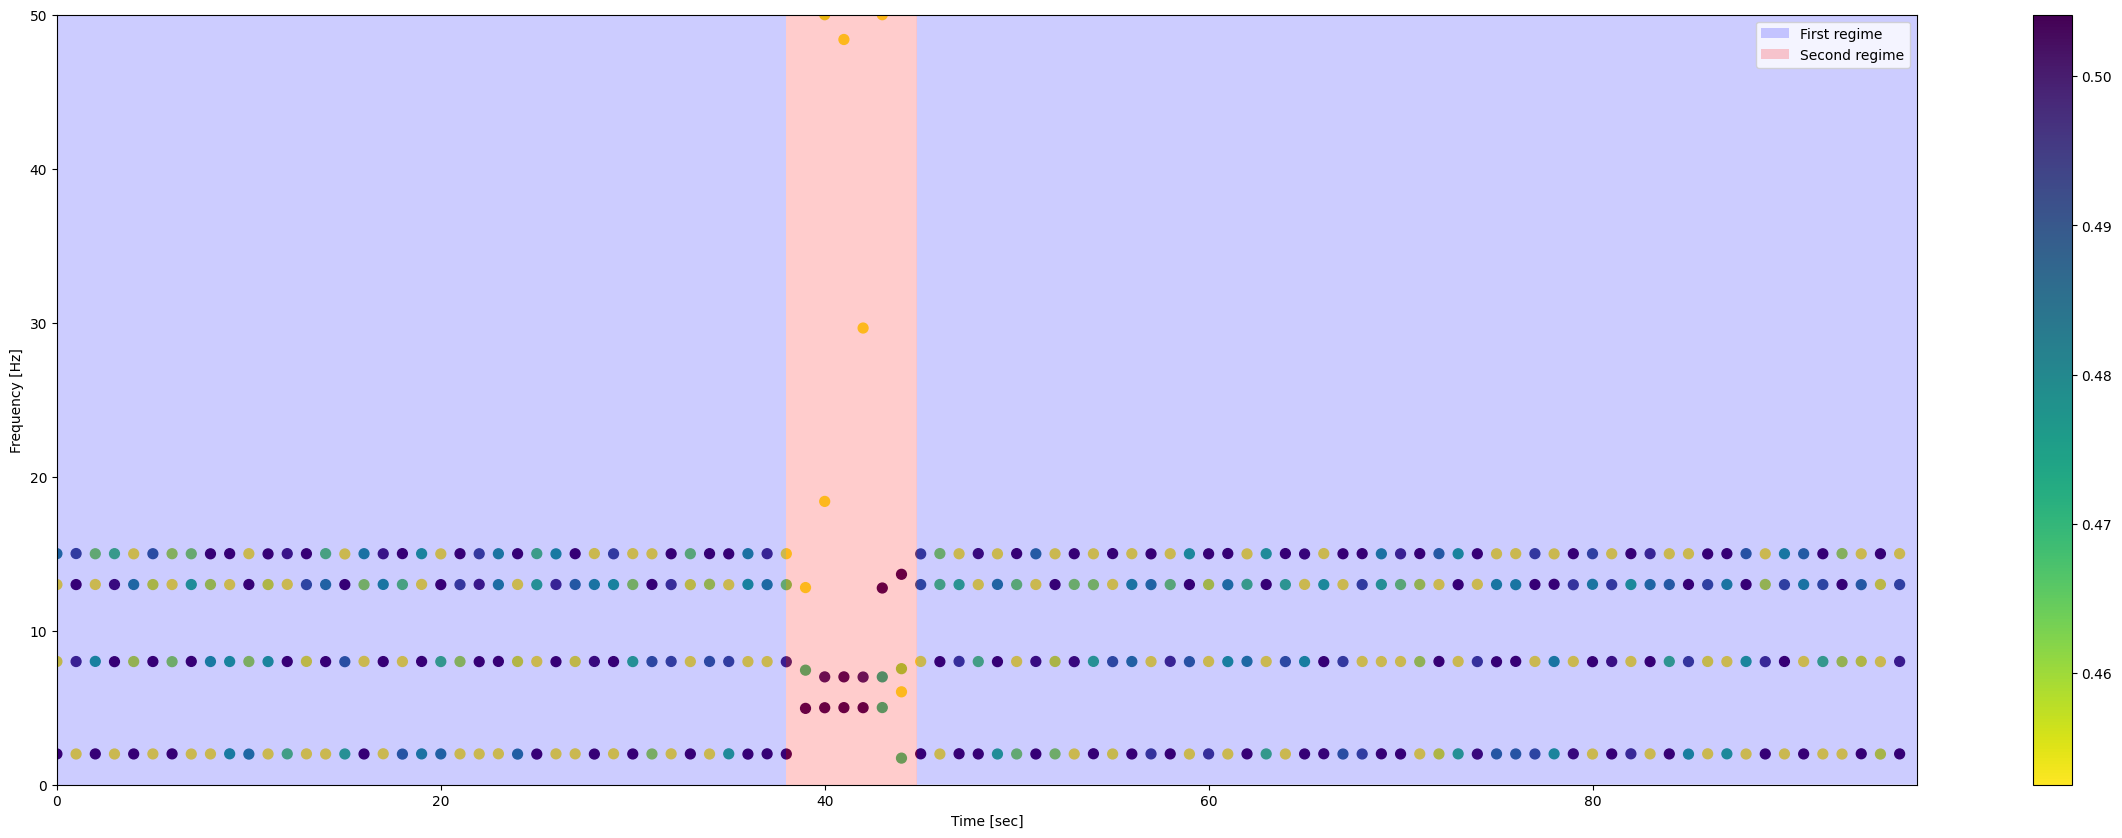

In [22]:
plt.figure(figsize=(30,10))
for i in range(0, xs.shape[0], 10):
    plt.scatter(x=xs[i], y=freqs[i], c=amplitudes[i], cmap='viridis_r', s=50)
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.fill_between(secs, 0, 50, where=first_regime, facecolor='blue', alpha=0.2, label='First regime')
plt.fill_between(secs, 0, 50, where=second_regime, facecolor='red', alpha=0.2, label='Second regime')
plt.margins(x=0, y=0)
plt.legend()
plt.show()

We have indeed recovered the two regimes present in our data.